# PCA on 4000 Spectra

Recreating https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/astronomy/dimensionality_reduction.html with 4000 spectra generated from compute_sdss_pca.py

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import chisquare
from astropy.table import Table

## 1. Load and prepare data

In [3]:
# Load full data set
data = np.load('spec4000error.npz')

In [4]:
# Calculating wavlength grid from coefficients
log_wavelengths = data['coeff0'] + data['coeff1'] * np.arange(0, 1000, 1)
wavelengths = [10**i for i in log_wavelengths]

In [5]:
#%% Selecting only galaxies (spec_cln = 2)
galaxy_ind = data['spec_cln'] == 2
X = data['spectra'][galaxy_ind]
subclass = data['lineindex_cln'][galaxy_ind]
z = data['z'][galaxy_ind]
z_err = data['zerr'][galaxy_ind]
spec_err = data['spec_err'][galaxy_ind]

In [6]:
#%% Set any negative spikes in flux to zero and set the corresponding error to zero
neg_ind = X <= 0.
X[neg_ind] = 0.
spec_err[neg_ind] = 0.

In [7]:
#%% Set zero fluxes to NaN
X_nonan = X.copy()
zero_ind = X == 0.
X[zero_ind] = np.NaN

In [8]:
#%% Set all zero flux errors to NaN
zero_err_ind = spec_err == 0.
spec_err[zero_err_ind] = np.NaN

## 2. Normalise X and plot mean spectrum

In [9]:
#%% Normalise spectrum
X_normal, norm = preprocessing.normalize(X_nonan, return_norm=True)
X_norm_zeros = np.copy(X_normal)

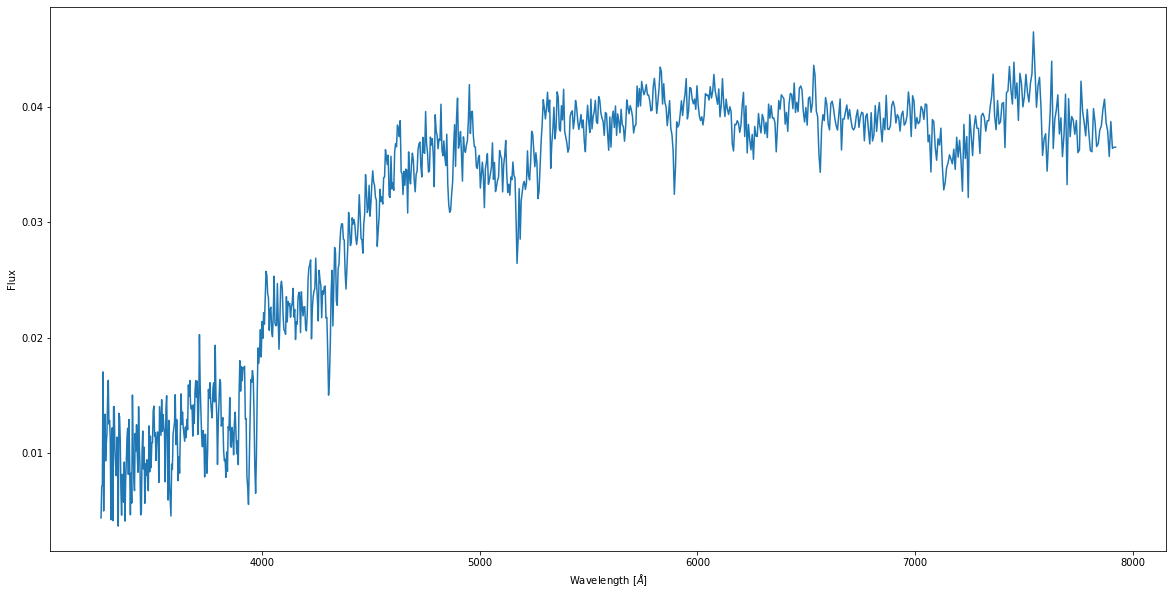

In [17]:
#%% Plot an example spectrum in the data
plt.figure(figsize=(20,10))
plt.plot(wavelengths,X_normal[4])
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Flux')
plt.show()

In [10]:
#%% Set all zero normalised fluxes to nan
zero_norm_ind = X_normal == 0.
X_normal[zero_norm_ind] = np.NaN

In [11]:
#%% Transform errors due to corresponding normalisation
spec_err_T = np.transpose(spec_err)
spec_err_norm_T = np.divide(spec_err_T,norm)
spec_err_norm = np.transpose(spec_err_norm_T)

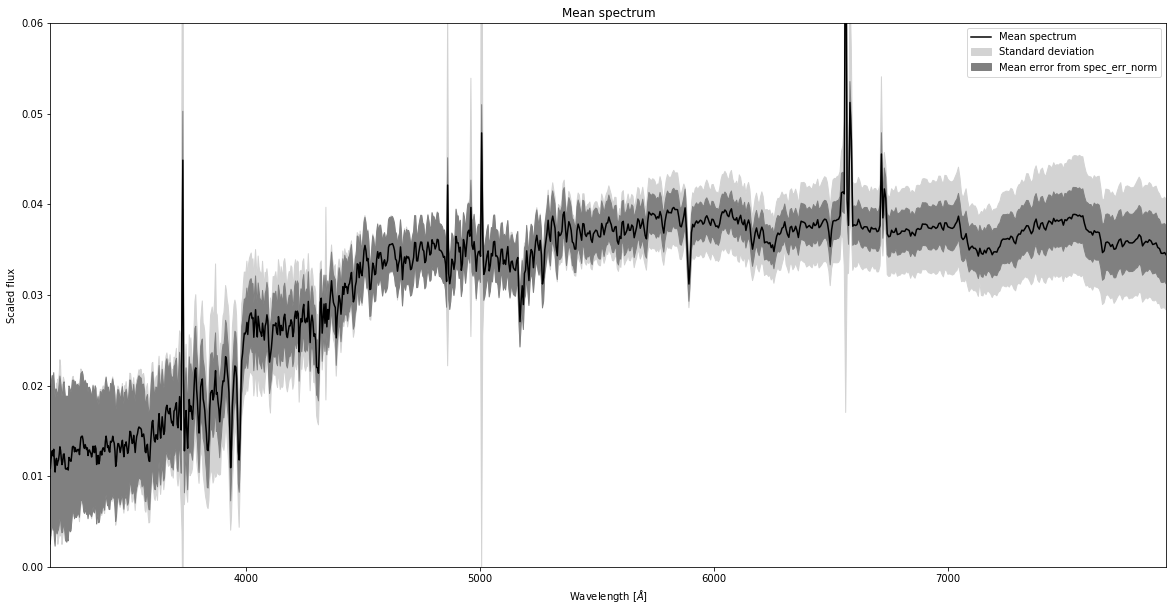

In [20]:
#%% Plot mean spectrum
mu = np.nanmean(X_normal, axis=0)
std = np.nanstd(X_normal, axis=0)
#mu = X_norm_zeros.mean(0)
#std = X_norm_zeros.std(0)
mean_err = np.nanmean(spec_err_norm, axis=0)
plt.figure(figsize=(20,10))
plt.plot(wavelengths, mu, color = 'black', label='Mean spectrum')
plt.fill_between(wavelengths, mu - std, mu + std , color = 'lightgrey', label='Standard deviation')
plt.fill_between(wavelengths, mu - mean_err, mu + mean_err , color = 'grey', label = 'Mean error from SDSS')
plt.xlim(wavelengths[0], wavelengths[-1])
plt.ylim(0,0.06)
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Scaled flux')
plt.title('Mean spectrum')
plt.legend()
plt.show()

## 3. Apply PCA

In [12]:
pca = PCA(n_components=4)
X_red = pca.fit_transform(X_norm_zeros)

## 4. Plot the cofficients from X_red against each other

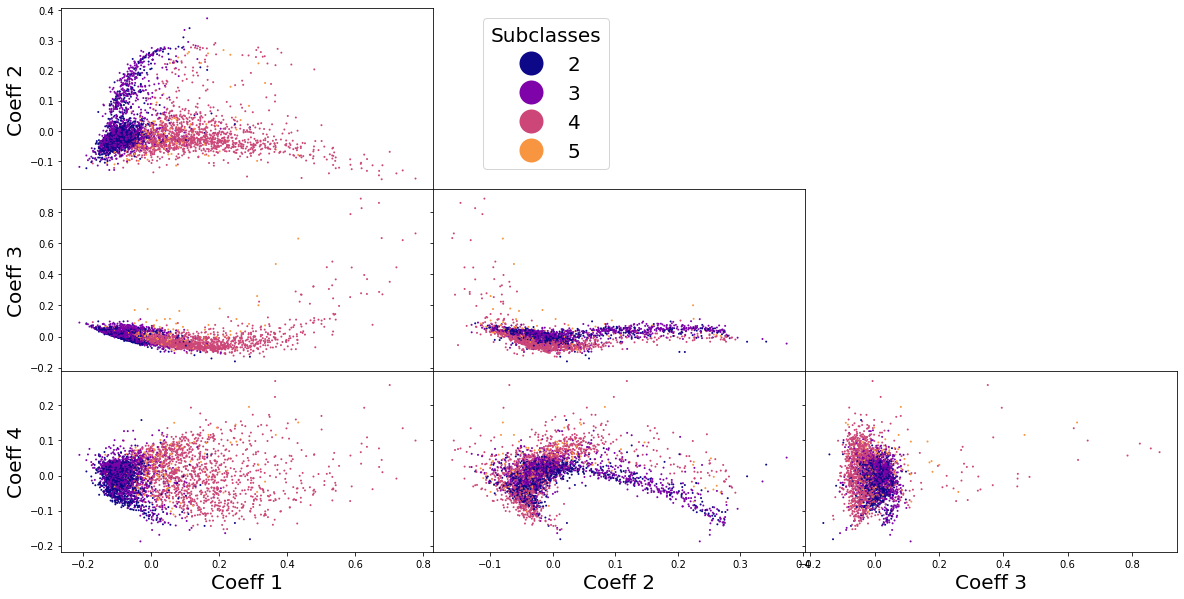

In [13]:
plt.figure(figsize=(20,10))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.set_cmap('plasma')

ax1 = plt.subplot(3,3,1)
scatter1 = ax1.scatter(X_red[:, 0], X_red[:, 1], c = subclass, s=4, lw=0, vmin=2, vmax=6)
ax1.set_ylabel('Coeff 2', fontsize=20)

ax2 = plt.subplot(3,3,4)
ax2.scatter(X_red[:, 0], X_red[:, 2], c = subclass, s=4, lw=0, vmin=2, vmax=6)
ax2.set_ylabel('Coeff 3', fontsize=20)

ax3 = plt.subplot(3,3,5)
ax3.scatter(X_red[:, 1], X_red[:, 2], c = subclass, s=4, lw=0, vmin=2, vmax=6)

ax4 = plt.subplot(3,3,7)
ax4.scatter(X_red[:, 0], X_red[:, 3], c = subclass, s=4, lw=0, vmin=2, vmax=6)
ax4.set_xlabel('Coeff 1', fontsize=20)
ax4.set_ylabel('Coeff 4', fontsize=20)

ax5 = plt.subplot(3,3,8)
ax5.scatter(X_red[:, 1], X_red[:, 3], c = subclass, s=4, lw=0, vmin=2, vmax=6)
ax5.set_xlabel('Coeff 2', fontsize=20)

ax6 = plt.subplot(3,3,9)
ax6.scatter(X_red[:, 2], X_red[:, 3], c = subclass, s=4, lw=0, vmin=2, vmax=6)
ax6.set_xlabel('Coeff 3', fontsize=20)

plt.subplots_adjust(hspace=.0, wspace=.0)
axs = np.array([ax1, ax2, ax3, ax4, ax5, ax6])
for ax in axs.flat:
    ax.label_outer()
    
ax1.legend(*scatter1.legend_elements(), bbox_to_anchor=(1.5, 1), title="Subclasses",
                     fontsize=20, title_fontsize=20, markerscale=4)

plt.show()

## 5. Plot the mean spectrum and the first four eigenvectors of the spectral data

Text(0.5, 1.0, 'Mean Spectrum and Eigen-spectra')

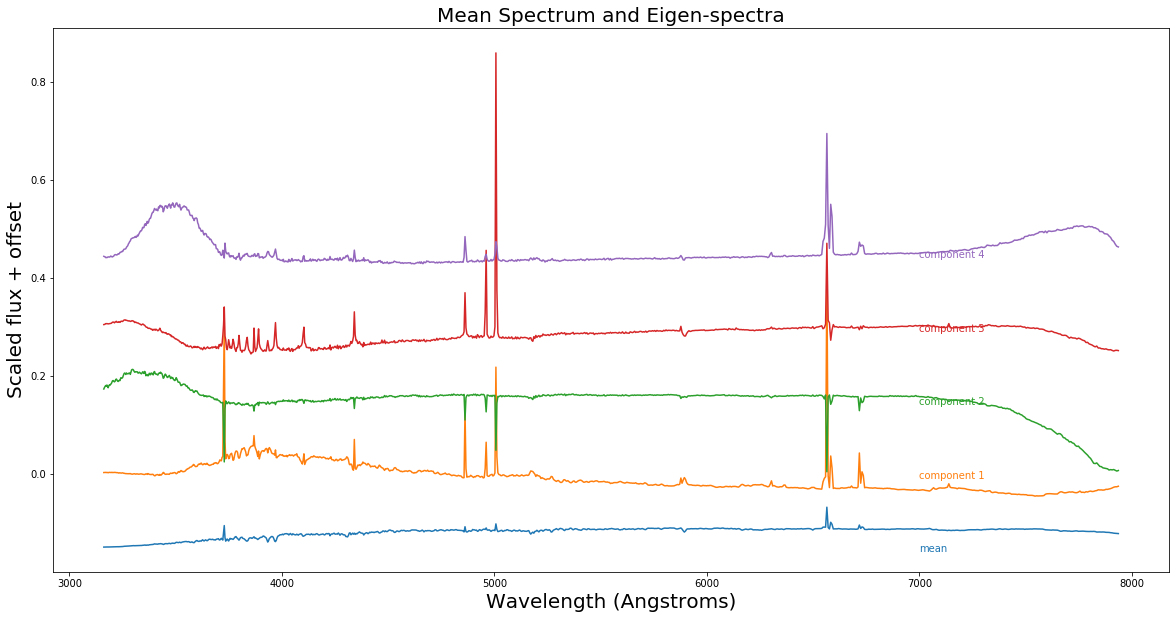

In [14]:
plt.figure(figsize=(20,10))
l = plt.plot(wavelengths, pca.mean_ - 0.15)
c = l[0].get_color()
plt.text(7000, -0.16, "mean", color=c)
for i in range(4):
    l = plt.plot(wavelengths, pca.components_[i] + 0.15 * i)
    c = l[0].get_color()
    plt.text(7000, -0.01 + 0.15 * i, "component %i" % (i + 1), color=c)
#plt.ylim(-0.2, 0.6)
plt.xlabel('Wavelength (Angstroms)', fontsize=20)
plt.ylabel('Scaled flux + offset', fontsize=20)
plt.title('Mean Spectrum and Eigen-spectra', fontsize=20)

## 6. Plot variance explained by each component

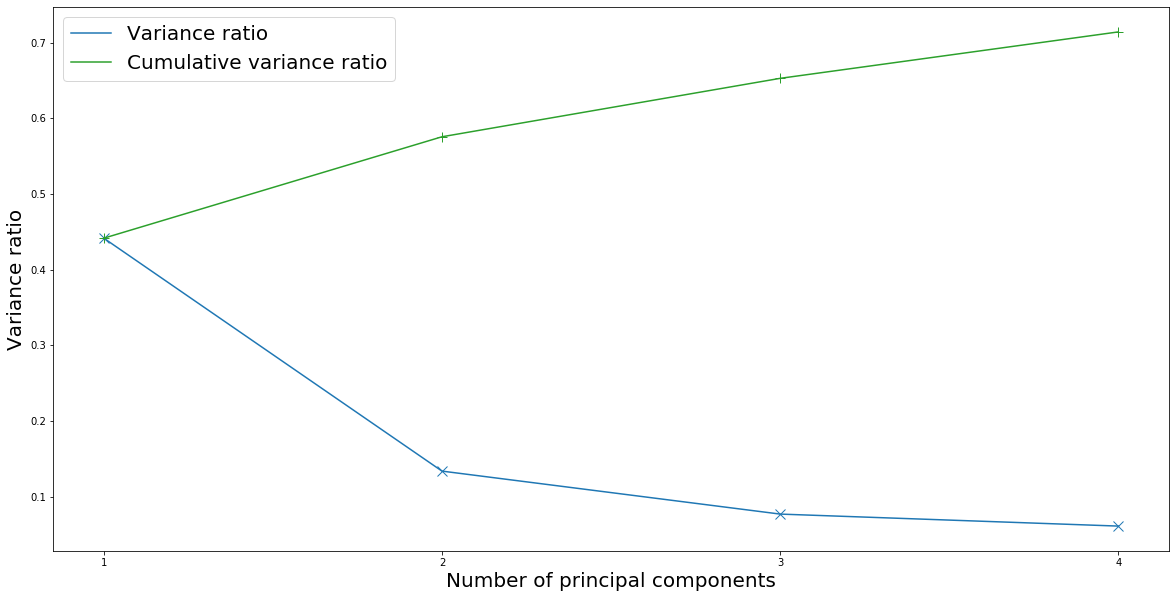

In [15]:
var = pca.explained_variance_ratio_
cum_var = np.cumsum(var)
plt.figure(figsize=(20,10))
plt.plot(np.array(range(1,pca.n_components_+1)), var, 'x', color='tab:blue', markersize=10)
plt.plot(np.array(range(1,pca.n_components_+1)), var, color='tab:blue', label='Variance ratio')
plt.plot(np.array(range(1,pca.n_components_+1)), cum_var, '+', color='tab:green', markersize=10)
plt.plot(np.array(range(1,pca.n_components_+1)), cum_var, color='tab:green', label='Cumulative variance ratio')
plt.xlabel('Number of principal components',fontsize=20)
plt.ylabel('Variance ratio',fontsize=20)
plt.xticks(np.array(range(1,pca.n_components_+1)))
plt.legend(fontsize=20)
plt.show()

## 7. Reconstruct a random individual spectra

In [21]:
def reconstruct_spectra(spectra_num, components=4,plot_fig=True):
    '''
    Returns reconstruction of a spectrum using the total number of components in the reduced dataset and plots the reconstructed
    spectrum and the original spectrum on the same figure.
    
    Input:
    spectra_num: Index of desired spectrum
    components: Number of components from reduced dataset to use in reconstruction. Default is 4.
    plot_fig: If plot_fig=True, a plot of the reconstruction and the original spectrum will be shown, with subplots showing an
              increasing number of components used in the reconstruction
    
    Returns: 1D array of the reconstructed spectrum 
    '''
    coeff = np.dot(pca.components_, X_norm_zeros[spectra_num] - pca.mean_)
    if plot_fig == True:
        fig = plt.figure(figsize=(20,10))
        for i, n in enumerate(range(components+1)):
            ax = fig.add_subplot(511 + i)
            ax.plot(wavelengths, X_norm_zeros[spectra_num], '-', c='gray', label='Original')
            ax.plot(wavelengths, pca.mean_ + np.dot(coeff[:n], pca.components_[:n]), '-k', label='Reconstruction')
        
            if i < 3:
                ax.xaxis.set_major_formatter(plt.NullFormatter())
        
            ax.set_ylabel('flux', fontsize=20)
        
            if n == 0:
                text = "mean"
            elif n == 1:
                text = "mean + 1 component\n"
                text += r"$(\sigma^2_{tot}$ ratio $= %.2f)$" % cum_var[n - 1]
            else:
                text = "mean + %i components\n" % n
                text += r"$(\sigma^2_{tot}$ ratio $= %.2f)$" % cum_var[n - 1]
        
            ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)
        fig.axes[-1].legend()    
        fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$', fontsize=20)
        fig.suptitle(f'Reconstruction of Spectra {spectra_num} (lineindex_cln=={subclass[spectra_num]})', fontsize=20)
        plt.show()
    return pca.mean_ + np.dot(coeff[:components], pca.components_[:components])

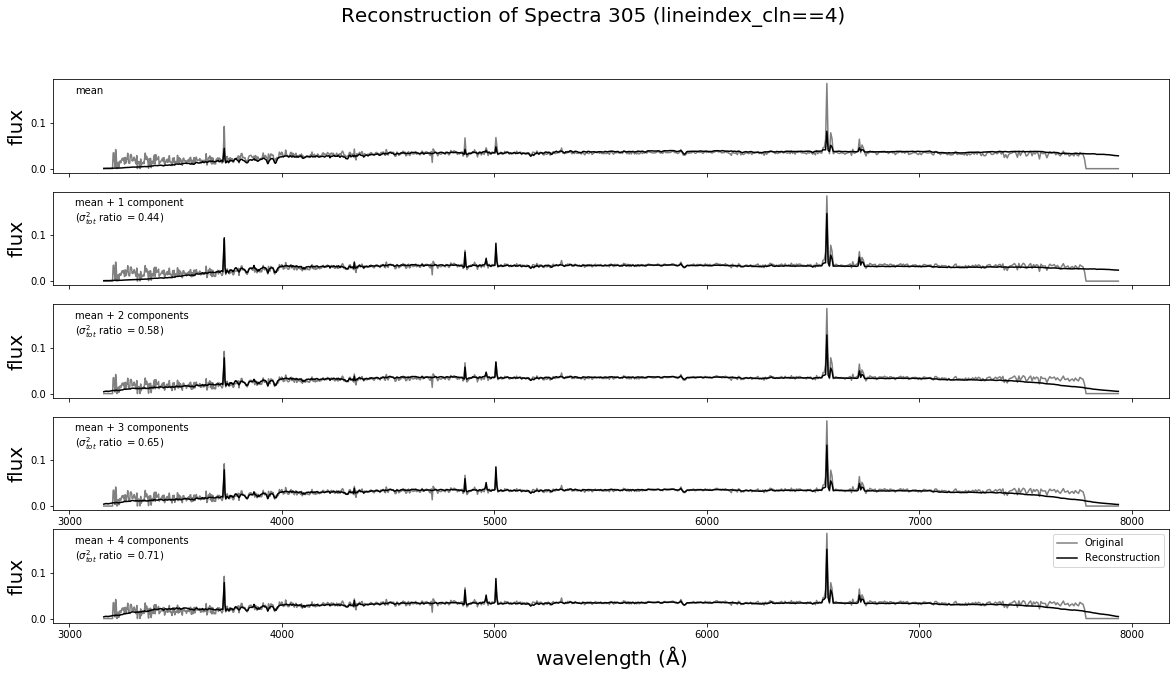

In [22]:
# Plot a random spectra
spectra_num = np.random.randint(0, len(X))
_ = reconstruct_spectra(spectra_num)

## 8. Find $\chi^2$ test statistics for all 3872 spectra and plot histogram

In [29]:
def chisquare_no_zeros(reconstruction, original):
    '''
    Performs a chi-squared test, omitting the zero values in the reconstruction
    
    Input:
    reconstruction: Array of reconstructed spectrum
    original: Array of original spectrum
    
    Returns: (chi-squared test statistic, p-value)
    '''
    original_no_zeros = original[original != 0.0]
    chi = chisquare(reconstruction[original!=0.0], original_no_zeros)
    return chi

def chisquare_all(original_arr):
    '''
    Performs a chi-squared test, omitting the zero values in the reconstruction, for all spectra in a specified array.
    
    Input:
    original_arr: Multi-dimensional array of spectra
    
    Returns:
    chi_arr: Array of chi-squared test statistics
    chi_p: Array of chi-squared p values
    '''
    chi_arr = np.array([])
    p_arr = np.array([])
    for i in range(len(original_arr)):
        reconstruction = reconstruct_spectra(i,plot_fig=False)
        chi_test,chi_p = chisquare_no_zeros(reconstruction, original_arr[i])
        chi_arr = np.append(chi_arr, chi_test)
        p_arr = np.append(p_arr, chi_p)
    return chi_arr, p_arr

chi_arr = chisquare_all(X_norm_zeros)

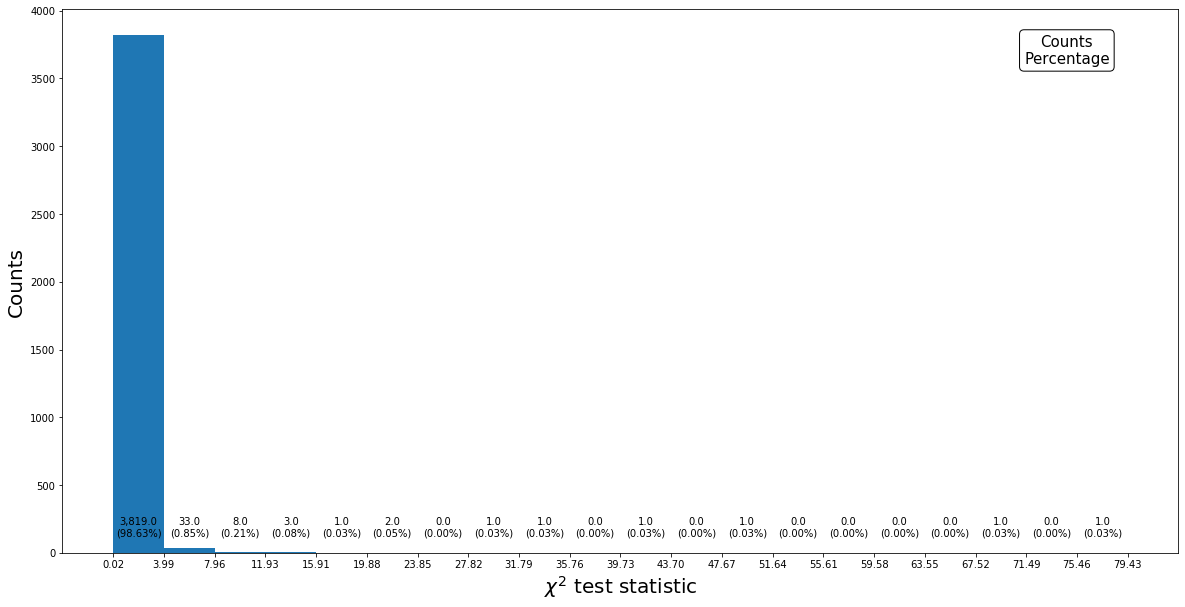

In [27]:
# %% Plot histogram chi-squared values
# Code adapted from https://towardsdatascience.com/advanced-histogram-using-python-bceae288e715
fig, ax = plt.subplots(figsize=(20,10))
counts, bins, patches = ax.hist(chi_arr, bins=20)

# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins.round(2))
        
# Calculate bar centre to display the count of data points and %
bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
bin_y_centers = ax.get_yticks()[1] * 0.25

# Display the the count of data points and % for each bar in histogram
for i in range(len(bins)-1):
    bin_label = "{0:,}".format(counts[i]) + "\n({0:,.2f}%)".format((counts[i]/counts.sum())*100)
    plt.text(bin_x_centers[i], bin_y_centers, bin_label, horizontalalignment='center')    

ax.annotate('Counts\nPercentage', xy=(0.9,0.9), xycoords='axes fraction', 
            horizontalalignment='center', fontsize=15, bbox=dict(boxstyle="round", fc="white"))
plt.xlabel("$\chi^2$ test statistic", fontsize=20)
plt.ylabel('Counts',fontsize=20)

plt.show()

## 9. Store all reconstructed spectrums in Astropy Table along with original spectrums

In [45]:
# %% Make an Astropy Table to store reconstruction data
reconstruction_arr = np.zeros(X_norm_zeros.shape)
for i in range(len(X_norm_zeros)):
    reconstruction_arr[i] = reconstruct_spectra(i, plot_fig=False)

reconstruction_table = Table([np.arange(len(X_norm_zeros)), subclass, X_norm_zeros, reconstruction_arr],
                                        names=('index', 'subclass', 'original', 'reconstruction'),)

reconstruction_table[:5]

index,subclass,original [1000],reconstruction [1000]
int32,int32,float32,float64
0,3,0.0 .. 0.039052933,-0.00045389134902507067 .. 0.03653707355260849
1,3,0.0 .. 0.04112339,-0.0008495853981003165 .. 0.036837998777627945
2,3,0.0 .. 0.038850885,-0.00028653047047555447 .. 0.03391551971435547
3,2,0.0 .. 0.035754688,-2.8500857297331095e-05 .. 0.03216198459267616
4,2,0.0 .. 0.0,0.000641550577711314 .. 0.02811138704419136


## 10. Filter reconstructions by subclass and plot histograms of $\chi^2$ values for each subclass

In [37]:
# %% Filter reconstructions by subclass
absorption = reconstruction_table[reconstruction_table['subclass']==2]
normal = reconstruction_table[reconstruction_table['subclass']==3]
emission = reconstruction_table[reconstruction_table['subclass']==4]
narrow_qso = reconstruction_table[reconstruction_table['subclass']==5]

2: Absorption galaxy


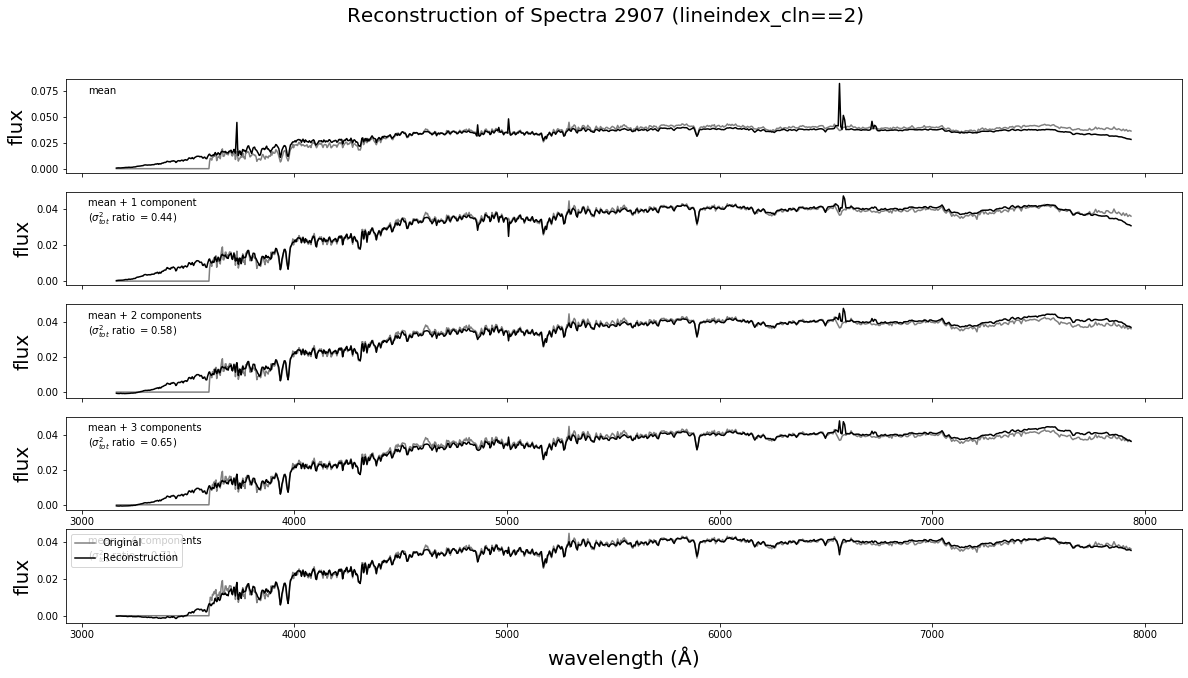

3: Normal galaxy


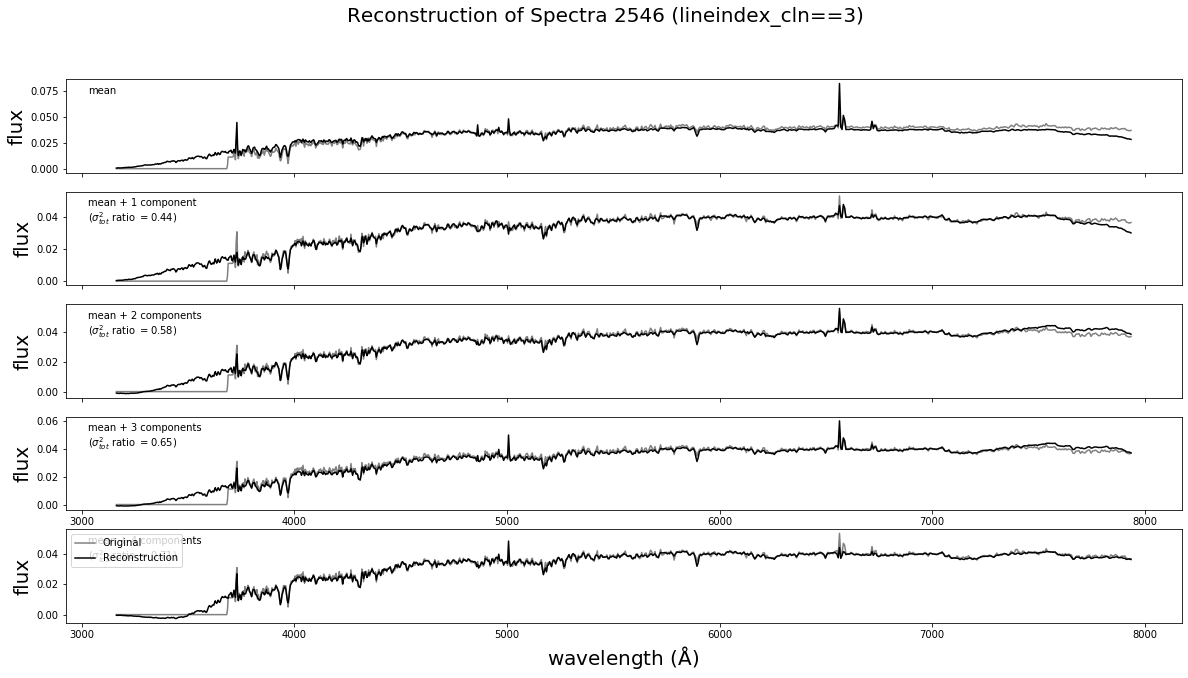

4: Emission galaxy


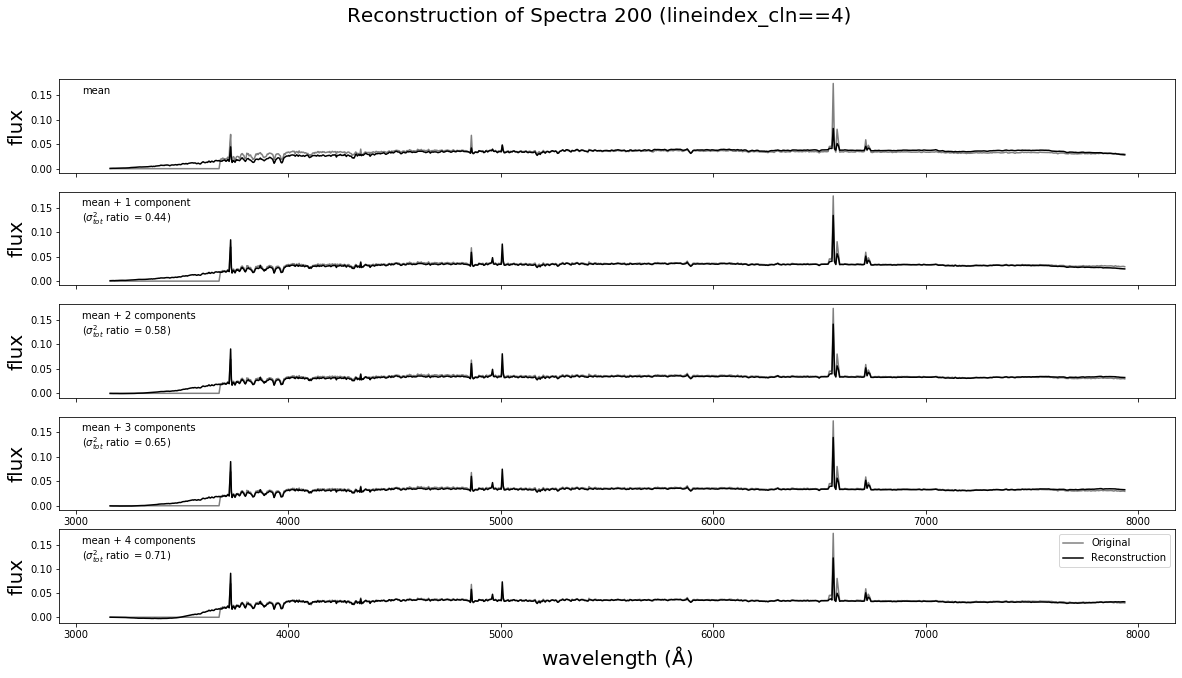

5: Narrow line QSO


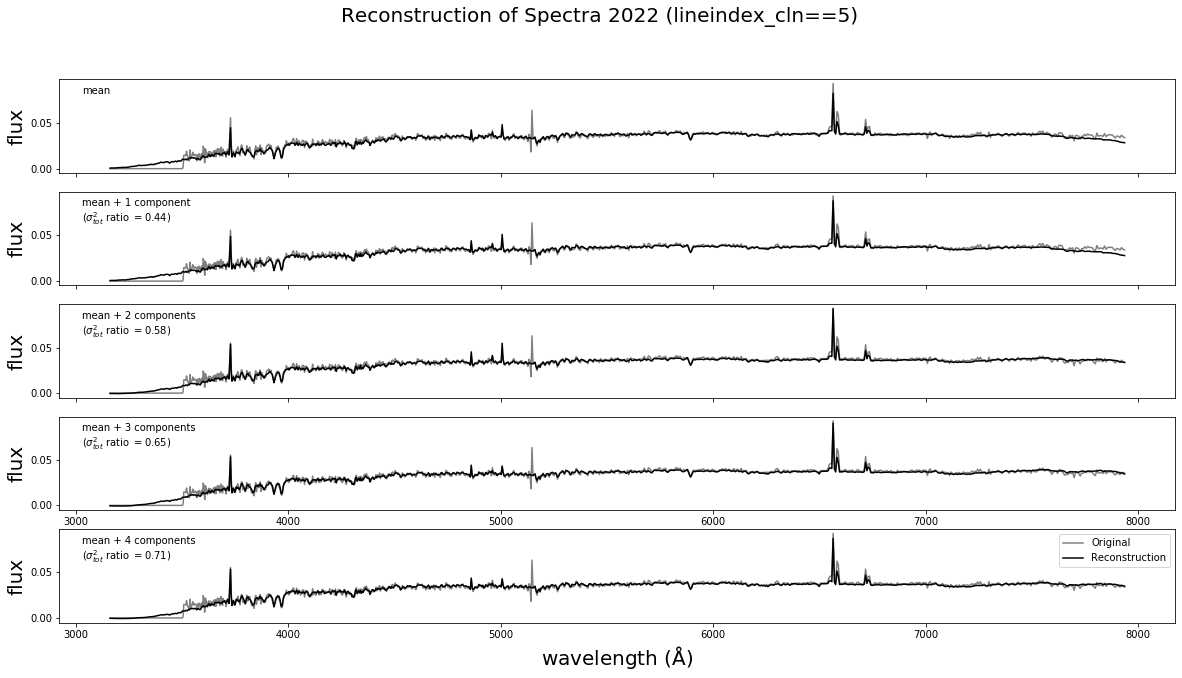

In [42]:
# %% Plot reconstruction for one example from each subclass
print('2: Absorption galaxy')
_ = reconstruct_spectra(np.random.choice(absorption['index']))
print('3: Normal galaxy')
_ = reconstruct_spectra(np.random.choice(normal['index']))
print('4: Emission galaxy')
_ = reconstruct_spectra(np.random.choice(emission['index']))
print('5: Narrow line QSO')
_ = reconstruct_spectra(np.random.choice(narrow_qso['index']))

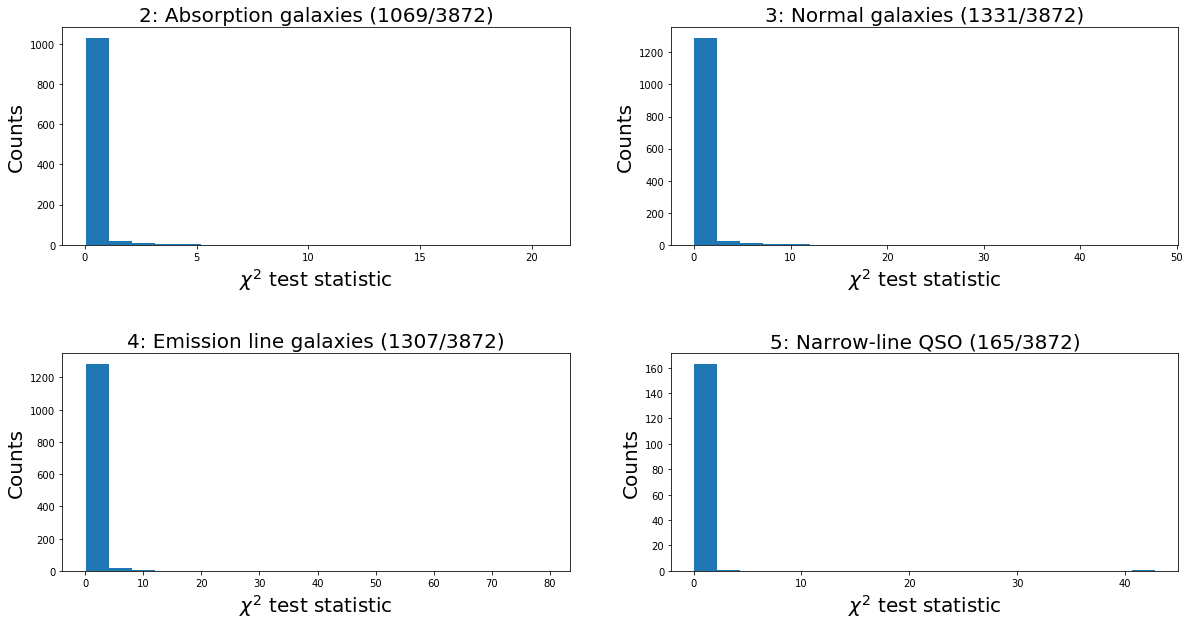

In [41]:
# %% Plot chi-squared value histograms for each subclass
plt.figure(figsize=(20,10))
ax1 = plt.subplot(2,2,1)
counts, bins, patches = ax1.hist(chi_arr[subclass == 2], bins=20)
# ax1.set_xticks(bins.round(2))
# bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
# bin_y_centers = ax1.get_yticks()[1] * 0.25
# for i in range(len(bins)-1):
#     bin_label = "{0:,}".format(counts[i]) + "\n({0:,.2f}%)".format((counts[i]/counts.sum())*100)
#     ax1.text(bin_x_centers[i], bin_y_centers, bin_label, horizontalalignment='center')    

# ax1.annotate('Counts\nPercentage', xy=(0.9,0.9), xycoords='axes fraction', 
#             horizontalalignment='center', fontsize=15, bbox=dict(boxstyle="round", fc="white"))
ax1.set_xlabel("$\chi^2$ test statistic", fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
ax1.set_title(f'2: Absorption galaxies ({len(chi_arr[subclass == 2])}/{len(subclass)})', fontsize=20)

ax2 = plt.subplot(2,2,2)
counts, bins, patches = ax2.hist(chi_arr[subclass == 3], bins=20)
# ax2.set_xticks(bins.round(2))
# bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
# bin_y_centers = ax2.get_yticks()[1] * 0.25
# for i in range(len(bins)-1):
#     bin_label = "{0:,}".format(counts[i]) + "\n({0:,.2f}%)".format((counts[i]/counts.sum())*100)
#     ax2.text(bin_x_centers[i], bin_y_centers, bin_label, horizontalalignment='center')    

# ax2.annotate('Counts\nPercentage', xy=(0.9,0.9), xycoords='axes fraction', 
#             horizontalalignment='center', fontsize=15, bbox=dict(boxstyle="round", fc="white"))
ax2.set_xlabel("$\chi^2$ test statistic", fontsize=20)
ax2.set_ylabel('Counts',fontsize=20)
ax2.set_title(f'3: Normal galaxies ({len(chi_arr[subclass == 3])}/{len(subclass)})', fontsize=20)

ax3 = plt.subplot(2,2,3)
counts, bins, patches = ax3.hist(chi_arr[subclass == 4], bins=20)
# ax3.set_xticks(bins.round(2))
# bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
# bin_y_centers = ax3.get_yticks()[1] * 0.25
# for i in range(len(bins)-1):
#     bin_label = "{0:,}".format(counts[i]) + "\n({0:,.2f}%)".format((counts[i]/counts.sum())*100)
#     ax3.text(bin_x_centers[i], bin_y_centers, bin_label, horizontalalignment='center')    

# ax3.annotate('Counts\nPercentage', xy=(0.9,0.9), xycoords='axes fraction', 
#             horizontalalignment='center', fontsize=15, bbox=dict(boxstyle="round", fc="white"))
ax3.set_xlabel("$\chi^2$ test statistic", fontsize=20)
ax3.set_ylabel('Counts',fontsize=20)
ax3.set_title(f'4: Emission line galaxies ({len(chi_arr[subclass == 4])}/{len(subclass)})', fontsize=20)

ax4 = plt.subplot(2,2,4)
counts, bins, patches = ax4.hist(chi_arr[subclass == 5], bins=20)
# ax4.set_xticks(bins.round(2))
# bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
# bin_y_centers = ax4.get_yticks()[1] * 0.25
# for i in range(len(bins)-1):
#     bin_label = "{0:,}".format(counts[i]) + "\n({0:,.2f}%)".format((counts[i]/counts.sum())*100)
#     ax4.text(bin_x_centers[i], bin_y_centers, bin_label, horizontalalignment='center')    

# ax4.annotate('Counts\nPercentage', xy=(0.9,0.9), xycoords='axes fraction', 
#             horizontalalignment='center', fontsize=15, bbox=dict(boxstyle="round", fc="white"))
ax4.set_xlabel("$\chi^2$ test statistic", fontsize=20)
ax4.set_ylabel('Counts',fontsize=20)
ax4.set_title(f'5: Narrow-line QSO ({len(chi_arr[subclass == 5])}/{len(subclass)})', fontsize=20)

plt.subplots_adjust(hspace=.5, wspace=.2)
plt.show()